# Import Libraries

In [81]:
import random
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Phase 1: Getting Cards

In [115]:
#Define function to take the list of current cards in the deck, pick a random card, and remove it
#Returns the chosen card and the now-smaller deck
def choose_card(current_deck):
    if len(current_deck) == 0:
        current_deck = list(range(1, 14, 1)) * 4
    card = random.choice(current_deck)
    current_deck.remove(card)
    return card, current_deck

In [127]:
#function to simulate a single getting cards phase
def getting_cards(current_deck = list(range(1, 14, 1)) * 4):
    #initialize a deck and counting variables
    drinks_taken = 0
    drinks_given = 0
    cards_in_hand = []

    #draw the first card
    first_card, current_deck = choose_card(current_deck)
    cards_in_hand.append(first_card)

    #random choice for winning first card
    if random.choice([1, 0]) == 1:
        drinks_taken += 1
    else:
        drinks_given += 1

    #assign choice for second round
    if first_card > 7:
        second_choice = 'low'
    elif first_card < 7:
        second_choice = 'high'
    else:
        second_choice = random.choice(['high', 'low'])

    #draw the second card
    second_card, current_deck = choose_card(current_deck)
    cards_in_hand.append(second_card)

    #check to see if the first two cards are equal. If so, increase stakes.
    second_card_drink_stake = 1
    while second_card == first_card:
        second_card_drink_stake += 1
        second_card, current_deck = choose_card(current_deck)
        cards_in_hand.append(second_card)

    #determine if second choice was correct
    if (second_card > first_card) & (second_choice == 'high'):
        drinks_given += second_card_drink_stake
    elif (second_card < first_card) & (second_choice == 'low'):
        drinks_given += second_card_drink_stake
    else:
        drinks_taken += second_card_drink_stake

    #assign choice for third round
    if abs(first_card - second_card) - 1 < 6:
        third_choice = 'outside'
    else:
        third_choice = 'inside'

    #draw the third card
    third_card, current_deck = choose_card(current_deck)
    cards_in_hand.append(third_card)

    #check to see if the third card equals either of the first two cards. If so, increase stakes.
    third_card_drink_stake = 1
    while (third_card == first_card) or (third_card == second_card):
        third_card_drink_stake += 1
        third_card, current_deck = choose_card(current_deck)
        cards_in_hand.append(third_card)

    #determine if third choice was correct
    if (third_card < max(first_card, second_card)) and (third_card > min(first_card, second_card)) and (third_choice == 'inside'):
        drinks_given += third_card_drink_stake
    elif ((third_card > max(first_card, second_card)) or (third_card < min(first_card, second_card))) and (third_choice == 'outside'):
        drinks_given += third_card_drink_stake
    else:
        drinks_taken += third_card_drink_stake

    #draw the fourth card
    fourth_card, current_deck = choose_card(current_deck)
    cards_in_hand.append(fourth_card)

    #random choice for winning fourth card
    if random.choice([1, 0, 0, 0]) == 1:
        drinks_given += 1
    else:
        drinks_taken += 1
    
    #return list of drinks info, list of cards in hand, and current deck
    return [drinks_taken, drinks_given], cards_in_hand, current_deck

In [117]:
#run 1m simulations of getting cards
getting_cards_results = []
for i in range(1000000):
    drinks, cards_in_hand, current_deck = getting_cards()
    getting_cards_results.append(drinks)

In [118]:
#turn simulation results into pivot table
getting_cards_df = DataFrame(getting_cards_results, columns = ['taken', 'given']).reset_index()
getting_cards_pivot = (getting_cards_df.pivot_table(values = 'index', index = 'given', 
                                                   columns = 'taken', aggfunc = 'count', fill_value = 0)/1000000).round(2)

In [176]:
#print relevant information
print('Average Drinks Taken while getting cards:', getting_cards_df['taken'].mean())
print('Average Drinks Given while getting cards:', getting_cards_df['given'].mean())

Average Drinks Taken while getting cards: 1.751819
Average Drinks Given while getting cards: 2.441685


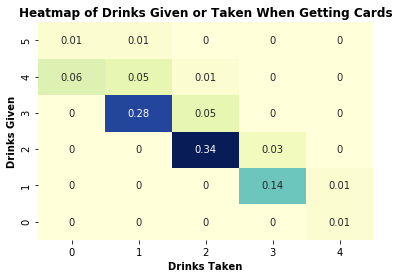

In [120]:
#make heatmap of pivot table
ax = sns.heatmap(getting_cards_pivot.loc[:5,:4], cmap="YlGnBu", annot = True, cbar = False)
ax.invert_yaxis()

plt.xlabel('Drinks Taken', fontweight = 'bold')
plt.ylabel("Drinks Given", fontweight = 'bold')
plt.title("Heatmap of Drinks Given or Taken When Getting Cards", fontweight = 'bold')

plt.savefig('ride_the_bus/getting_cards_heatmap.png', dpi = 500, bbox_inches = 'tight')

# Phase 2: The Pyramid

In [155]:
#function to simulate a single pyramid phase
def pyramid(players): 
    #initialize some variables
    current_deck = list(range(1, 14, 1)) * 4
    cards_in_hand_list = []
    drinks_given_list = [0] * players

    #give out cards to players
    for i in range(players):
        drinks, cards_in_hand, current_deck = getting_cards(current_deck)
        cards_in_hand_list.append(cards_in_hand)

    #iterate over each pyramid step
    for i in range(10):
        pyramid_card, current_deck = choose_card(current_deck)

        #calculate stake of pyramid level
        if i <= 3:
            stake = 1
        elif i <= 6:
            stake = 2
        elif i <= 8:
            stake = 3
        else:
            stake = 4

        #iterate over each players hand, calculate drinks given, and remove cards
        for j in range(players):
            if pyramid_card in cards_in_hand_list[j]:        
                drinks_given_list[j] = drinks_given_list[j] + (cards_in_hand_list[j].count(pyramid_card) * stake)
                cards_in_hand_list[j] = [x for x in cards_in_hand_list[j] if x != pyramid_card]

    #check if player 1 has to ride the bus
    if len(cards_in_hand_list[0]) == max([len(x) for x in cards_in_hand_list]):
        riding_bus = 1
    else:
        riding_bus = 0

    #return relevant info for player 1
    return [drinks_given_list[0], players, riding_bus]

In [168]:
#run simulations of the pyramid for varied numbers of players
pyramid_results = []
for i in range(2,13):
    for j in range(10000):
        pyramid_results.append(pyramid(i))

In [170]:
#create dataframe of pyramid results
pyramid_df = DataFrame(pyramid_results, columns = ['given', 'players', 'riding_bus'])

In [175]:
#print relevant info
print('Average drinks given during pyramid:', pyramid_df['given'].mean())

Average drinks given during pyramid: 3.922727272727273


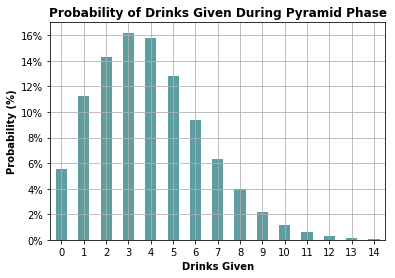

In [209]:
#plot distribution of drinks given while playing the pyramid
pyramid_df['given'].value_counts(normalize = True).sort_index().plot(kind = 'bar', color = 'cadetblue')

plt.xticks(rotation = 0)
plt.yticks([x/100 for x in range(0, 18, 2)], [str(x) + '%' for x in range(0, 18, 2)])

plt.xlim(-0.5, 14.5)

plt.grid(True)

plt.xlabel('Drinks Given', fontweight = 'bold')
plt.ylabel("Probability (%)", fontweight = 'bold')
plt.title("Probability of Drinks Given During Pyramid Phase", fontweight = 'bold')

plt.savefig('ride_the_bus/pyramid_results.png', dpi = 500, bbox_inches = 'tight')

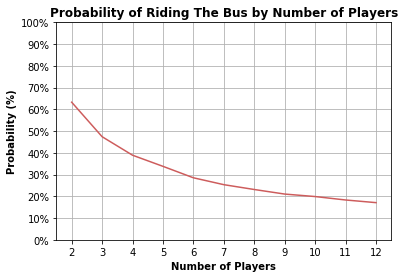

In [207]:
#plot probability of riding the bus by number of players
pyramid_df.groupby('players').mean()['riding_bus'].plot(color = 'indianred')

plt.yticks([x/100 for x in range(0, 101, 10)], [str(x) + '%' for x in range(0, 101, 10)])
plt.xticks(range(2,13))

plt.ylim(0, 1)

plt.grid(True)

plt.xlabel('Number of Players', fontweight = 'bold')
plt.ylabel("Probability (%)", fontweight = 'bold')
plt.title("Probability of Riding The Bus by Number of Players", fontweight = 'bold')

plt.savefig('ride_the_bus/riding_bus_odds.png', dpi = 500, bbox_inches = 'tight')

# Phase 3: Riding The Bus

In [6]:
#function to shuffle the deck while taking into account currently placed bus cards
def shuffle_deck_bus(bus_stop_dict):
    new_deck = list(range(1, 14, 1)) * 4
    for j in bus_stop_dict.values():
        new_deck.remove(j)
    return new_deck

In [7]:
#function to initialize bus cards in order
def make_bus_dict(current_deck):
    bus_stop_dict = {}
    for i in range(1, 8):
        card, current_deck = choose_card(current_deck)
        bus_stop_dict[i] = card
    return bus_stop_dict, current_deck

In [8]:
#function to play a single bus card while riding the bus
def play_single_bus_stop(current_deck, bus_stop_dict, current_bus_stop, drinks_taken):
    #assign choice for bus card
    if bus_stop_dict[current_bus_stop] > 7:
        choice = 'low'
    elif bus_stop_dict[current_bus_stop] < 7:
        choice = 'high'
    else:
        choice = random.choice(['high', 'low'])
    
    #reshuffle deck if empty
    if len(current_deck) == 0:
        current_deck = shuffle_deck_bus(bus_stop_dict)
    
    #reveal a card
    placed_card, current_deck = choose_card(current_deck)
    
    #if cards are equal, raise drink stakes and reveal another card
    drink_stake = 1
    while placed_card == bus_stop_dict[current_bus_stop]:
        drink_stake += 1

        if len(current_deck) == 0:
            current_deck = shuffle_deck_bus(bus_stop_dict)

        placed_card, current_deck = choose_card(current_deck)
    
    #determine if choice was correct, change the bus stop, and add drinks if needed
    if (placed_card > bus_stop_dict[current_bus_stop]) & (choice == 'high'):
        next_bus_stop = current_bus_stop + 1
    elif (placed_card < bus_stop_dict[current_bus_stop]) & (choice == 'low'):
        next_bus_stop = current_bus_stop + 1
    else:
        next_bus_stop = 1
        drinks_taken += drink_stake

    #change bus stop card to revealed card
    bus_stop_dict[current_bus_stop] = placed_card
    
    #return relevant info
    return current_deck, bus_stop_dict, next_bus_stop, drinks_taken

In [9]:
#function to simulate a single riding the bus phase
def ride_the_bus():
    #initialize some variables
    current_deck = list(range(1, 14, 1)) * 4
    bus_stop_dict, current_deck = make_bus_dict(current_deck)
    current_bus_stop = 1
    drinks_taken = 0

    #iterate over bus stops using play_single_bus_stop until all bus stops are played
    while current_bus_stop != 8:
        current_deck, bus_stop_dict, current_bus_stop, drinks_taken = play_single_bus_stop(
                current_deck, bus_stop_dict, current_bus_stop, drinks_taken)
        
    #return number of drinks taken
    return drinks_taken

In [189]:
#simualte bus phase many times
bus_results = []
for i in range(1000000):
    bus_results.append(ride_the_bus())

In [190]:
#print relevant info
print("Average Drinks Taken while riding the bus:", np.mean(bus_results).round(2))

Average Drinks Taken while riding the bus: 4.92


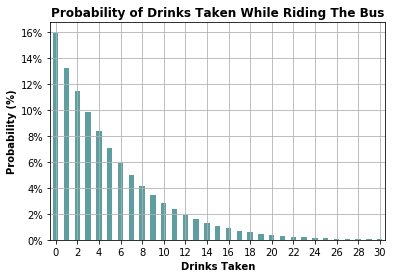

In [191]:
#plot distribution of drinks taken while riding the bus
Series(bus_results).value_counts(normalize = True).plot(kind = 'bar', color = 'cadetblue')

plt.xticks(range(0, 32, 2), range(0, 32, 2), rotation = 0)
plt.yticks([x/100 for x in range(0, 18, 2)], [str(x) + '%' for x in range(0, 18, 2)])

plt.xlim(-0.5, 30.5)

plt.grid(True)

plt.xlabel('Drinks Taken', fontweight = 'bold')
plt.ylabel("Probability (%)", fontweight = 'bold')
plt.title("Probability of Drinks Taken While Riding The Bus", fontweight = 'bold')

plt.savefig('ride_the_bus/ride_the_bus_density.png', dpi = 500, bbox_inches = 'tight')

In [192]:
#create reverse cumulative distribution in dictionary
results_cumulative_dict = {}
for i in range(0, 41, 1):
    count = 0
    for j in bus_results:
        if j >= i:
            count += 1
    results_cumulative_dict[i] = count / len(bus_results)

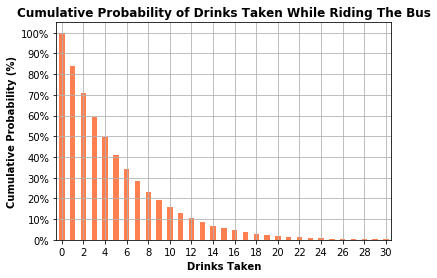

In [193]:
#plot reverse cumulative distribution of drinks taken
Series(results_cumulative_dict).plot(kind = 'bar', color = 'coral')

plt.xticks(range(0, 32, 2), range(0, 32, 2), rotation = 0)
plt.yticks([x/100 for x in range(0, 101, 10)], [str(x) + '%' for x in range(0, 101, 10)])

plt.xlim(-0.5, 30.5)

plt.grid(True)

plt.xlabel('Drinks Taken', fontweight = 'bold')
plt.ylabel("Cumulative Probability (%)", fontweight = 'bold')
plt.title("Cumulative Probability of Drinks Taken While Riding The Bus", fontweight = 'bold')

plt.savefig('ride_the_bus/ride_the_bus_cumulative.png', dpi = 500, bbox_inches = 'tight')